# 개요
커널이 통과합니다.
1. 데이터를 로드하기 위한 사전 처리 단계입니다.
1. 색 공간을 빠르게 시각화합니다.
1. 간단한 CNN을 훈련합니다.
1. 테스트 데이터에 모델을 적용합니다.
1. RLE 테스트 데이터를 생성합니다.

# 요약
label,path-.groupby-ii-sumstack-expand-cnn-dice-t_mask-rle
                   -iironlfobo*

### 1. label 읽어오기 
### 2. 이미지경로검색/분리(path  -> ImageId, ImageType, TrainingSplit, Stage)
### 3. train/test 
### 4. groupby(['Stage', 'ImageId']) -> image/mask # 변수: 'Stage', 'ImageId','masks','images' 
### 5. 숫자화 + img/mask 각각합치기 #np.sum(np.stack([imread(c_img) for c_img in in_img_list], 0), 0)/255.0)
### 6. .imshow()
### 7. 데이터 차원증가 #np.expand_dims(c_row['images'],0), np.expand_dims(np.expand_dims(c_row['masks'],-1),0)
### 8. cnn(sbc) + dice_coef -> .imshow()
### 9. test의 img+모델로 mask 예측 # test_img_df['masks'] = test_img_df['images'].map(lambda x: simple_cnn.predict(np.expand_dims(x, 0))[0, :, :, 0]))
### 10. .imshow()
### 11. rle 인코딩 #mask로 rle변수를 만듦

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from glob import glob
import os
from skimage.io import imread
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
dsb_data_dir = os.path.join('.', 'input')
stage_label = 'stage1'

In [2]:
dsb_data_dir

'.\\input'

# Read in the labels
train 세트에 대한 RLE 인코딩 출력을 로드합니다.


In [3]:
# './input/stage1_train_labels.csv'
train_labels = pd.read_csv(os.path.join(dsb_data_dir,'{}_train_labels.csv'.format(stage_label)))
train_labels

ImageId  \
0      00071198d059ba7f5914a526d124d28e6d010c92466da2...   
1      00071198d059ba7f5914a526d124d28e6d010c92466da2...   
2      00071198d059ba7f5914a526d124d28e6d010c92466da2...   
3      00071198d059ba7f5914a526d124d28e6d010c92466da2...   
4      00071198d059ba7f5914a526d124d28e6d010c92466da2...   
...                                                  ...   
29456  ff599c7301daa1f783924ac8cbe3ce7b42878f15a39c2d...   
29457  ff599c7301daa1f783924ac8cbe3ce7b42878f15a39c2d...   
29458  ff599c7301daa1f783924ac8cbe3ce7b42878f15a39c2d...   
29459  ff599c7301daa1f783924ac8cbe3ce7b42878f15a39c2d...   
29460  ff599c7301daa1f783924ac8cbe3ce7b42878f15a39c2d...   

                                           EncodedPixels  
0      6908 1 7161 8 7417 8 7672 9 7928 9 8184 9 8440...  
1      36269 7 36523 11 36778 13 37033 15 37288 17 37...  
2      19919 6 20174 8 20429 10 20685 11 20941 12 211...  
3      18671 6 18926 8 19181 9 19436 10 19691 11 1994...  
4                40158 3 40413 5 40669 5 40925 5 41182 3  
...                                                  ...  
29456  31317 2 31676 5 32035 6 32394 7 32753 8 33112 ...  
29457  110318 4 110675 13 111034 19 111391 23 111750 ...  
29458  24841 1 25201 2 25561 2 25921 3 26281 4 26641 ...  
29459  4061 8 4417 14 4775 21 5134 23 5494 24 5853 26...  
29460  80876 11 81234 15 81590 20 81948 23 82305 27 8...  

[29461 rows x 2 columns]

In [4]:
train_labels['EncodedPixels'] = train_labels['EncodedPixels'].map(lambda ep: [int(x) for x in ep.split(' ')])
train_labels.sample(3)

ImageId  \
2756   150b0ffa318c87b31d78af0e87d60390dbcd84b5f228a8...   
24018  cb4df20a83b2f38b394c67f1d9d4aef29f9794d5345da3...   
6345   34c9f4eb2af8b8f46b1d88b74bde16f4614cd08948c2f1...   

                                           EncodedPixels  
2756   [130952, 8, 131471, 10, 131990, 13, 132509, 15...  
24018  [155838, 5, 156439, 8, 157039, 11, 157641, 12,...  
6345   [20294, 5, 20549, 7, 20804, 9, 21059, 10, 2131...

# Load in all Images
여기서는 이미지를 로드하고 경로를 처리하여 각 이미지에 대한 적절한 정보를 제공합니다.


In [5]:
all_images = glob(os.path.join(dsb_data_dir, 'stage1_*', '*', '*', '*'))
all_images

['.\\input\\stage1_test\\0114f484a16c152baa2d82fdd43740880a762c93f436c8988ac461c5c9dbe7d5\\images\\0114f484a16c152baa2d82fdd43740880a762c93f436c8988ac461c5c9dbe7d5.png',
 '.\\input\\stage1_test\\0999dab07b11bc85fb8464fc36c947fbd8b5d6ec49817361cb780659ca805eac\\images\\0999dab07b11bc85fb8464fc36c947fbd8b5d6ec49817361cb780659ca805eac.png',
 '.\\input\\stage1_test\\0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed30a90c8ca99092ae732\\images\\0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed30a90c8ca99092ae732.png',
 '.\\input\\stage1_test\\0e132f71c8b4875c3c2dd7a22997468a3e842b46aa9bd47cf7b0e8b7d63f0925\\images\\0e132f71c8b4875c3c2dd7a22997468a3e842b46aa9bd47cf7b0e8b7d63f0925.png',
 '.\\input\\stage1_test\\0ed3555a4bd48046d3b63d8baf03a5aa97e523aa483aaa07459e7afa39fb96c6\\images\\0ed3555a4bd48046d3b63d8baf03a5aa97e523aa483aaa07459e7afa39fb96c6.png',
 '.\\input\\stage1_test\\0f1f896d9ae5a04752d3239c690402c022db4d72c0d2c087d73380896f72c466\\images\\0f1f896d9ae5a04752d3239c690402c022db4d72c0d2c087d73

In [6]:
all_images = glob(os.path.join(dsb_data_dir, 'stage1_*', '*', '*', '*'))

img_df = pd.DataFrame({'path': all_images})
img_df['ImageId'] = img_df['path'].map(lambda in_path: in_path.split('\\')[-3])
img_df['ImageType'] = img_df['path'].map(lambda in_path: in_path.split('\\')[-2])
img_df['TrainingSplit'] = img_df['path'].map(lambda in_path: in_path.split('\\')[-4].split('_')[1])
img_df['Stage'] = img_df['path'].map(lambda in_path: in_path.split('\\')[-4].split('_')[0])
img_df.sample(2)

path  \
30185  .\input\stage1_train\ff599c7301daa1f783924ac8c...   
22383  .\input\stage1_train\b76ff33ae9da28f9cd8bdce46...   

                                                 ImageId ImageType  \
30185  ff599c7301daa1f783924ac8cbe3ce7b42878f15a39c2d...     masks   
22383  b76ff33ae9da28f9cd8bdce465d45f1eca399db3ffa838...     masks   

      TrainingSplit   Stage  
30185         train  stage1  
22383         train  stage1

## Create Training Data

Here we make training data and load all the images into the dataframe. We take a simplification here of grouping all the regions together (rather than keeping them distinct).



In [7]:
train_df = img_df.query('TrainingSplit=="train"')
train_df

path  \
65     .\input\stage1_train\00071198d059ba7f5914a526d...   
66     .\input\stage1_train\00071198d059ba7f5914a526d...   
67     .\input\stage1_train\00071198d059ba7f5914a526d...   
68     .\input\stage1_train\00071198d059ba7f5914a526d...   
69     .\input\stage1_train\00071198d059ba7f5914a526d...   
...                                                  ...   
30191  .\input\stage1_train\ff599c7301daa1f783924ac8c...   
30192  .\input\stage1_train\ff599c7301daa1f783924ac8c...   
30193  .\input\stage1_train\ff599c7301daa1f783924ac8c...   
30194  .\input\stage1_train\ff599c7301daa1f783924ac8c...   
30195  .\input\stage1_train\ff599c7301daa1f783924ac8c...   

                                                 ImageId ImageType  \
65     00071198d059ba7f5914a526d124d28e6d010c92466da2...    images   
66     00071198d059ba7f5914a526d124d28e6d010c92466da2...     masks   
67     00071198d059ba7f5914a526d124d28e6d010c92466da2...     masks   
68     00071198d059ba7f5914a526d124d28e6d010c92466da2...     masks   
69     00071198d059ba7f5914a526d124d28e6d010c92466da2...     masks   
...                                                  ...       ...   
30191  ff599c7301daa1f783924ac8cbe3ce7b42878f15a39c2d...     masks   
30192  ff599c7301daa1f783924ac8cbe3ce7b42878f15a39c2d...     masks   
30193  ff599c7301daa1f783924ac8cbe3ce7b42878f15a39c2d...     masks   
30194  ff599c7301daa1f783924ac8cbe3ce7b42878f15a39c2d...     masks   
30195  ff599c7301daa1f783924ac8cbe3ce7b42878f15a39c2d...     masks   

      TrainingSplit   Stage  
65            train  stage1  
66            train  stage1  
67            train  stage1  
68            train  stage1  
69            train  stage1  
...             ...     ...  
30191         train  stage1  
30192         train  stage1  
30193         train  stage1  
30194         train  stage1  
30195         train  stage1  

[30131 rows x 5 columns]

In [8]:
train_df.groupby(['Stage', 'ImageId'])

In [10]:
for n_group, n_rows in train_df.groupby(['Stage', 'ImageId']):
    print(n_group)

('stage1', '00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552')
('stage1', '003cee89357d9fe13516167fd67b609a164651b21934585648c740d2c3d86dc1')
('stage1', '00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e')
('stage1', '0121d6759c5adb290c8e828fc882f37dfaf3663ec885c663859948c154a443ed')
('stage1', '01d44a26f6680c42ba94c9bc6339228579a95d0e2695b149b7cc0c9592b21baf')
('stage1', '0280fa8f60f6bcae0f97d93c28f60be194f9309ff610dc5845e60455b0f87c21')
('stage1', '0287e7ee5b007c91ae2bd7628d09735e70496bc6127ecb7f3dd043e04ce37426')
('stage1', '02903040e19ddf92f452907644ad3822918f54af41dd85e5a3fe3e1b6d6f9339')
('stage1', '03398329ced0c23b9ac3fac84dd53a87d9ffe4d9d10f1b5fe8df8fac12380776')
('stage1', '03b9306f44e9b8951461623dcbd615550cdcf36ea93b203f2c8fa58ed1dffcbe')
('stage1', '03f583ec5018739f4abb9b3b4a580ac43bd933c4337ad8877aa18b1dfb59fc9a')
('stage1', '0402a81e75262469925ea893b6706183832e85324f7b1e08e634129f5d522cdd')
('stage1', '04acab7636c4cf61d288a5962f15fa456b7bde31

In [11]:
for n_group, n_rows in train_df.groupby(['Stage', 'ImageId']):
    print(n_rows)

                                                 path  \
65  .\input\stage1_train\00071198d059ba7f5914a526d...   
66  .\input\stage1_train\00071198d059ba7f5914a526d...   
67  .\input\stage1_train\00071198d059ba7f5914a526d...   
68  .\input\stage1_train\00071198d059ba7f5914a526d...   
69  .\input\stage1_train\00071198d059ba7f5914a526d...   
70  .\input\stage1_train\00071198d059ba7f5914a526d...   
71  .\input\stage1_train\00071198d059ba7f5914a526d...   
72  .\input\stage1_train\00071198d059ba7f5914a526d...   
73  .\input\stage1_train\00071198d059ba7f5914a526d...   
74  .\input\stage1_train\00071198d059ba7f5914a526d...   
75  .\input\stage1_train\00071198d059ba7f5914a526d...   
76  .\input\stage1_train\00071198d059ba7f5914a526d...   
77  .\input\stage1_train\00071198d059ba7f5914a526d...   
78  .\input\stage1_train\00071198d059ba7f5914a526d...   
79  .\input\stage1_train\00071198d059ba7f5914a526d...   
80  .\input\stage1_train\00071198d059ba7f5914a526d...   
81  .\input\stage1_train\000711

In [13]:
for n_group, n_rows in train_df.groupby(['Stage', 'ImageId']):
    c_row = {col_name: col_value for col_name, col_value in zip(['Stage', 'ImageId'], n_group)}
    print(c_row)

{'Stage': 'stage1', 'ImageId': '00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552'}
{'Stage': 'stage1', 'ImageId': '003cee89357d9fe13516167fd67b609a164651b21934585648c740d2c3d86dc1'}
{'Stage': 'stage1', 'ImageId': '00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e'}
{'Stage': 'stage1', 'ImageId': '0121d6759c5adb290c8e828fc882f37dfaf3663ec885c663859948c154a443ed'}
{'Stage': 'stage1', 'ImageId': '01d44a26f6680c42ba94c9bc6339228579a95d0e2695b149b7cc0c9592b21baf'}
{'Stage': 'stage1', 'ImageId': '0280fa8f60f6bcae0f97d93c28f60be194f9309ff610dc5845e60455b0f87c21'}
{'Stage': 'stage1', 'ImageId': '0287e7ee5b007c91ae2bd7628d09735e70496bc6127ecb7f3dd043e04ce37426'}
{'Stage': 'stage1', 'ImageId': '02903040e19ddf92f452907644ad3822918f54af41dd85e5a3fe3e1b6d6f9339'}
{'Stage': 'stage1', 'ImageId': '03398329ced0c23b9ac3fac84dd53a87d9ffe4d9d10f1b5fe8df8fac12380776'}
{'Stage': 'stage1', 'ImageId': '03b9306f44e9b8951461623dcbd615550cdcf36ea93b203f2c8fa58ed1dffcbe'}
{'Stage': 

In [14]:
for n_group, n_rows in train_df.groupby(['Stage', 'ImageId']):
    c_row = {col_name: col_value for col_name, col_value in zip(['Stage', 'ImageId'], n_group)}
    c_row['masks'] = n_rows.query('ImageType == "masks"')['path'].values.tolist()
    print(c_row)

{'Stage': 'stage1', 'ImageId': '00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552', 'masks': ['.\\input\\stage1_train\\00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552\\masks\\07a9bf1d7594af2763c86e93f05d22c4d5181353c6d3ab30a345b908ffe5aadc.png', '.\\input\\stage1_train\\00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552\\masks\\0e548d0af63ab451616f082eb56bde13eb71f73dfda92a03fbe88ad42ebb4881.png', '.\\input\\stage1_train\\00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552\\masks\\0ea1f9e30124e4aef1407af239ff42fd6f5753c09b4c5cac5d08023c328d7f05.png', '.\\input\\stage1_train\\00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552\\masks\\0f5a3252d05ecdf453bdd5e6ad5322c454d8ec2d13ef0f0bf45a6f6db45b5639.png', '.\\input\\stage1_train\\00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552\\masks\\2c47735510ef91a11fde42b317829cee5fc04d05a797b90008803d7151951d58.png', '.\\input\\stage1_train\\00071198d059ba7f5914a

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [15]:
train_df = img_df.query('TrainingSplit=="train"')
train_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in train_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['masks'] = n_rows.query('ImageType == "masks"')['path'].values.tolist()
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    train_rows += [c_row]
train_img_df = pd.DataFrame(train_rows)
train_img_df

Stage                                            ImageId  \
0    stage1  00071198d059ba7f5914a526d124d28e6d010c92466da2...   
1    stage1  003cee89357d9fe13516167fd67b609a164651b2193458...   
2    stage1  00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b074...   
3    stage1  0121d6759c5adb290c8e828fc882f37dfaf3663ec885c6...   
4    stage1  01d44a26f6680c42ba94c9bc6339228579a95d0e2695b1...   
..      ...                                                ...   
665  stage1  fec226e45f49ab81ab71e0eaa1248ba09b56a328338dce...   
666  stage1  feffce59a1a3eb0a6a05992bb7423c39c7d52865846da3...   
667  stage1  ff3407842ada5bc18be79ae453e5bdaa1b68afc842fc22...   
668  stage1  ff3e512b5fb860e5855d0c05b6cf5a6bcc7792e4be1f0b...   
669  stage1  ff599c7301daa1f783924ac8cbe3ce7b42878f15a39c2d...   

                                                 masks  \
0    [.\input\stage1_train\00071198d059ba7f5914a526...   
1    [.\input\stage1_train\003cee89357d9fe13516167f...   
2    [.\input\stage1_train\00ae65c1c6631ae6f2be1a44...   
3    [.\input\stage1_train\0121d6759c5adb290c8e828f...   
4    [.\input\stage1_train\01d44a26f6680c42ba94c9bc...   
..                                                 ...   
665  [.\input\stage1_train\fec226e45f49ab81ab71e0ea...   
666  [.\input\stage1_train\feffce59a1a3eb0a6a05992b...   
667  [.\input\stage1_train\ff3407842ada5bc18be79ae4...   
668  [.\input\stage1_train\ff3e512b5fb860e5855d0c05...   
669  [.\input\stage1_train\ff599c7301daa1f783924ac8...   

                                                images  
0    [.\input\stage1_train\00071198d059ba7f5914a526...  
1    [.\input\stage1_train\003cee89357d9fe13516167f...  
2    [.\input\stage1_train\00ae65c1c6631ae6f2be1a44...  
3    [.\input\stage1_train\0121d6759c5adb290c8e828f...  
4    [.\input\stage1_train\01d44a26f6680c42ba94c9bc...  
..                                                 ...  
665  [.\input\stage1_train\fec226e45f49ab81ab71e0ea...  
666  [.\input\stage1_train\feffce59a1a3eb0a6a05992b...  
667  [.\input\stage1_train\ff3407842ada5bc18be79ae4...  
668  [.\input\stage1_train\ff3e512b5fb860e5855d0c05...  
669  [.\input\stage1_train\ff599c7301daa1f783924ac8...  

[670 rows x 4 columns]

In [8]:
train_df = img_df.query('TrainingSplit=="train"')
train_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in train_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['masks'] = n_rows.query('ImageType == "masks"')['path'].values.tolist()
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    train_rows += [c_row]
train_img_df = pd.DataFrame(train_rows)

IMG_CHANNELS = 3
def read_and_stack(in_img_list):
    return np.sum(np.stack([imread(c_img) for c_img in in_img_list], 0), 0)/255.0
train_img_df['images'] = train_img_df['images'].map(read_and_stack)
train_img_df['images'][0]

array([[[0.01960784, 0.01960784, 0.01960784, 1.        ],
        [0.01960784, 0.01960784, 0.01960784, 1.        ],
        [0.01960784, 0.01960784, 0.01960784, 1.        ],
        ...,
        [0.01568627, 0.01568627, 0.01568627, 1.        ],
        [0.01176471, 0.01176471, 0.01176471, 1.        ],
        [0.01176471, 0.01176471, 0.01176471, 1.        ]],

       [[0.02352941, 0.02352941, 0.02352941, 1.        ],
        [0.01960784, 0.01960784, 0.01960784, 1.        ],
        [0.01960784, 0.01960784, 0.01960784, 1.        ],
        ...,
        [0.01568627, 0.01568627, 0.01568627, 1.        ],
        [0.01568627, 0.01568627, 0.01568627, 1.        ],
        [0.01176471, 0.01176471, 0.01176471, 1.        ]],

       [[0.02352941, 0.02352941, 0.02352941, 1.        ],
        [0.01960784, 0.01960784, 0.01960784, 1.        ],
        [0.01960784, 0.01960784, 0.01960784, 1.        ],
        ...,
        [0.01960784, 0.01960784, 0.01960784, 1.        ],
        [0.01568627, 0.015686

In [44]:
train_df = img_df.query('TrainingSplit=="train"')
train_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in train_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['masks'] = n_rows.query('ImageType == "masks"')['path'].values.tolist()
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    train_rows += [c_row]
train_img_df = pd.DataFrame(train_rows)

IMG_CHANNELS = 3
def read_and_stack(in_img_list):
    return np.sum(np.stack([imread(c_img) for c_img in in_img_list], 0), 0)/255.0
train_img_df['images'] = train_img_df['images'].map(read_and_stack).map(lambda x: x[:,:,:IMG_CHANNELS])
train_img_df['images'][0] # (256, 256, 3)

array([[[0.01960784, 0.01960784, 0.01960784],
        [0.01960784, 0.01960784, 0.01960784],
        [0.01960784, 0.01960784, 0.01960784],
        ...,
        [0.01568627, 0.01568627, 0.01568627],
        [0.01176471, 0.01176471, 0.01176471],
        [0.01176471, 0.01176471, 0.01176471]],

       [[0.02352941, 0.02352941, 0.02352941],
        [0.01960784, 0.01960784, 0.01960784],
        [0.01960784, 0.01960784, 0.01960784],
        ...,
        [0.01568627, 0.01568627, 0.01568627],
        [0.01568627, 0.01568627, 0.01568627],
        [0.01176471, 0.01176471, 0.01176471]],

       [[0.02352941, 0.02352941, 0.02352941],
        [0.01960784, 0.01960784, 0.01960784],
        [0.01960784, 0.01960784, 0.01960784],
        ...,
        [0.01960784, 0.01960784, 0.01960784],
        [0.01568627, 0.01568627, 0.01568627],
        [0.01176471, 0.01176471, 0.01176471]],

       ...,

       [[0.01176471, 0.01176471, 0.01176471],
        [0.01176471, 0.01176471, 0.01176471],
        [0.01176471, 0

In [20]:
train_df = img_df.query('TrainingSplit=="train"')
train_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in train_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['masks'] = n_rows.query('ImageType == "masks"')['path'].values.tolist()
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    train_rows += [c_row]
train_img_df = pd.DataFrame(train_rows)

IMG_CHANNELS = 3
def read_and_stack(in_img_list):
    return np.stack([imread(c_img) for c_img in in_img_list], 0)/255.0
train_img_df['images'] = train_img_df['images'].map(read_and_stack).map(lambda x: x[:,:,:IMG_CHANNELS])
train_img_df['images'][0] # (670,)

array([[[[0.01960784, 0.01960784, 0.01960784, 1.        ],
         [0.01960784, 0.01960784, 0.01960784, 1.        ],
         [0.01960784, 0.01960784, 0.01960784, 1.        ]],

        [[0.02352941, 0.02352941, 0.02352941, 1.        ],
         [0.01960784, 0.01960784, 0.01960784, 1.        ],
         [0.01960784, 0.01960784, 0.01960784, 1.        ]],

        [[0.02352941, 0.02352941, 0.02352941, 1.        ],
         [0.01960784, 0.01960784, 0.01960784, 1.        ],
         [0.01960784, 0.01960784, 0.01960784, 1.        ]],

        ...,

        [[0.01176471, 0.01176471, 0.01176471, 1.        ],
         [0.01176471, 0.01176471, 0.01176471, 1.        ],
         [0.01176471, 0.01176471, 0.01176471, 1.        ]],

        [[0.01176471, 0.01176471, 0.01176471, 1.        ],
         [0.01176471, 0.01176471, 0.01176471, 1.        ],
         [0.01176471, 0.01176471, 0.01176471, 1.        ]],

        [[0.01176471, 0.01176471, 0.01176471, 1.        ],
         [0.00784314, 0.00784314

In [9]:
%%time
train_df = img_df.query('TrainingSplit=="train"')
train_rows = []
group_cols = ['Stage', 'ImageId']
# df를 dict형태로 {'x1':'a', 'x2':'007'}
for n_group, n_rows in train_df.groupby(group_cols): # n_group=그룹들, n_rows=pd형태의 각 row
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['masks'] = n_rows.query('ImageType == "masks"')['path'].values.tolist()
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    train_rows += [c_row] # [{'x1':'a', 'x2':'007', 'x3':['./input/a']}]
train_img_df = pd.DataFrame(train_rows)

IMG_CHANNELS = 3
# 경로->숫자형->누적 더하기
def read_and_stack(in_img_list):
    return np.sum(np.stack([imread(c_img) for c_img in in_img_list], 0), 0)/255.0 # [.\input\stage1_train\a]를 숫자로 누적시키고 동일한 픽셀위치끼리 더함 
train_img_df['images'] = train_img_df['images'].map(read_and_stack).map(lambda x: x[:,:,:IMG_CHANNELS]) # 채널제거
train_img_df['masks'] = train_img_df['masks'].map(read_and_stack)
train_img_df.sample(1)

Wall time: 2min 49s


Stage                                            ImageId  \
534  stage1  c901794d1a421d52e5734500c0a2a8ca84651fb93b19ce...   

                                                 masks  \
534  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                                images  
534  [[[0.023529411764705882, 0.023529411764705882,...

# Show a few images
    
여기에서 단일 분할 알고리즘을 사용하기 어렵게 만드는 밝은 시야와 형광이 혼합되어 있는 세포의 몇 가지 이미지를 보여줍니다.


array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

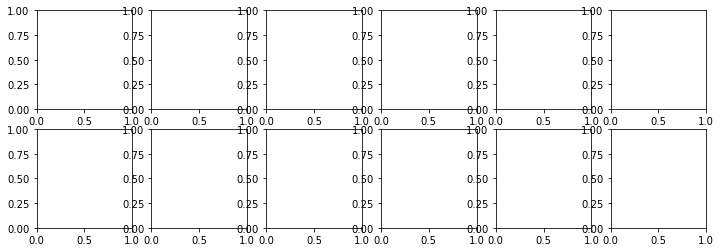

In [24]:
n_img = 6
fig, m_axs = plt.subplots(2, n_img, figsize = (12, 4))
m_axs

array([[<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>]], dtype=object)

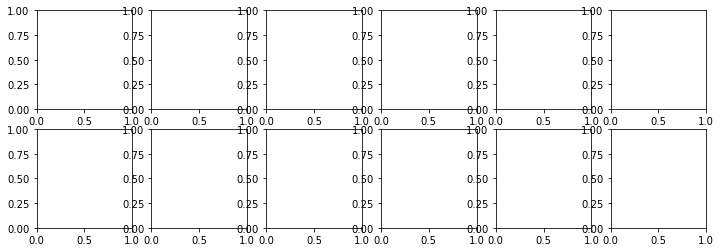

In [23]:
n_img = 6
fig, m_axs = plt.subplots(2, n_img, figsize = (12, 4))
m_axs.T

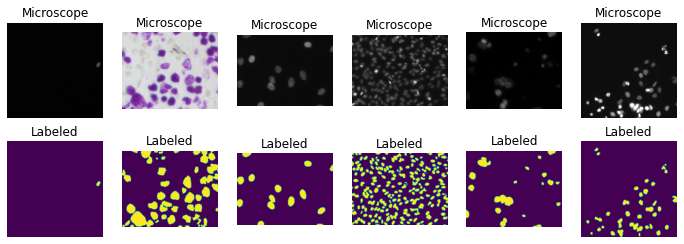

In [10]:
n_img = 6
fig, m_axs = plt.subplots(2, n_img, figsize = (12, 4))
for (_, c_row), (c_im, c_lab) in zip(train_img_df.sample(n_img).iterrows(), 
                                     m_axs.T):
    # images
    c_im.imshow(c_row['images'])
    c_im.axis('off')
    c_im.set_title('Microscope')
    
    # masks
    c_lab.imshow(c_row['masks'])
    c_lab.axis('off')
    c_lab.set_title('Labeled')

# Look at the intensity distribution
여기서 우리는 강도 분포를 간략하게 살펴보고 몇 개의 그룹이 형성되는 것을 볼 수 있습니다. 아마도 별도로 처리되어야 합니다.


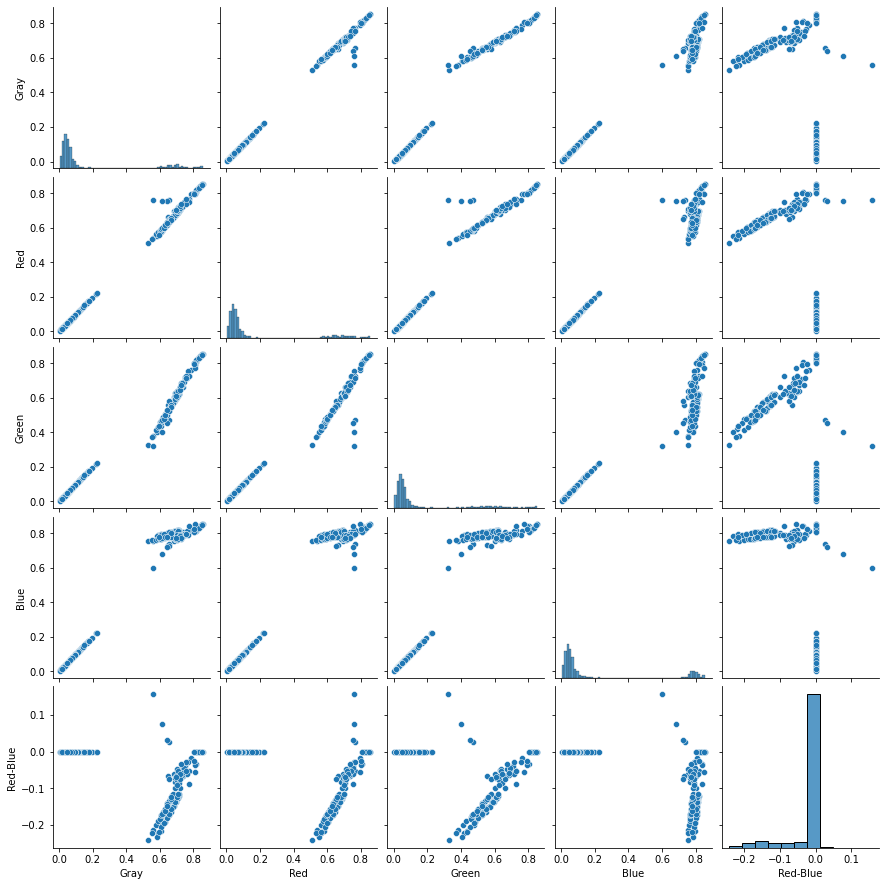

In [25]:
train_img_df['Red'] = train_img_df['images'].map(lambda x: np.mean(x[:,:,0]))
train_img_df['Green'] = train_img_df['images'].map(lambda x: np.mean(x[:,:,1]))
train_img_df['Blue'] = train_img_df['images'].map(lambda x: np.mean(x[:,:,2]))
train_img_df['Gray'] = train_img_df['images'].map(lambda x: np.mean(x))
train_img_df['Red-Blue'] = train_img_df['images'].map(lambda x: np.mean(x[:,:,0]-x[:,:,2]))
sns.pairplot(train_img_df[['Gray', 'Red', 'Green', 'Blue', 'Red-Blue']])

# Check Dimensions 
여기에서 입력 이미지의 다양성을 보기 위해 데이터의 차원을 보여줍니다.


In [26]:
train_img_df['images'].map(lambda x: x.shape).value_counts()

(256, 256, 3)      334
(256, 320, 3)      112
(520, 696, 3)       92
(360, 360, 3)       91
(1024, 1024, 3)     16
(512, 640, 3)       13
(603, 1272, 3)       6
(260, 347, 3)        5
(1040, 1388, 3)      1
Name: images, dtype: int64

## Making a simple CNN
여기에서 우리는 그것이 얼마나 잘 작동하는지에 대한 빠른 아이디어를 얻기 위해 매우 간단한 CNN을 만듭니다. 이를 위해 배치 정규화를 사용하여 입력을 정규화합니다. 문제를 단순하게 유지하기 위해 패딩으로 약간의 속임수를 사용합니다.


In [11]:
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, UpSampling2D, Lambda
simple_cnn = Sequential()
simple_cnn.add(BatchNormalization(input_shape = (None, None, IMG_CHANNELS), 
                                  name = 'NormalizeInput'))
simple_cnn.add(Conv2D(8, kernel_size = (3,3), padding = 'same'))
simple_cnn.add(Conv2D(8, kernel_size = (3,3), padding = 'same'))
# 확장= dilation_rate을 사용하여 시야를 조금 더 넓힙니다. 
simple_cnn.add(Conv2D(16, kernel_size = (3,3), dilation_rate = 2, padding = 'same'))
simple_cnn.add(Conv2D(16, kernel_size = (3,3), dilation_rate = 2, padding = 'same'))
simple_cnn.add(Conv2D(32, kernel_size = (3,3), dilation_rate = 3, padding = 'same'))

# the final processing
simple_cnn.add(Conv2D(16, kernel_size = (1,1), padding = 'same'))
simple_cnn.add(Conv2D(1, kernel_size = (1,1), padding = 'same', activation = 'sigmoid'))
simple_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NormalizeInput (BatchNormal  (None, None, None, 3)    12        
 ization)                                                        
                                                                 
 conv2d (Conv2D)             (None, None, None, 8)     224       
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 8)     584       
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 16)    1168      
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 16)    2320      
                                                                 
 conv2d_4 (Conv2D)           (None, None, None, 32)    4640      
                                                        

# Loss
합집합에 대한 교집합으로 평가되기 때문에 DICE 점수의 역함수를 손실 함수로 사용하여 최적화할 수 있습니다.


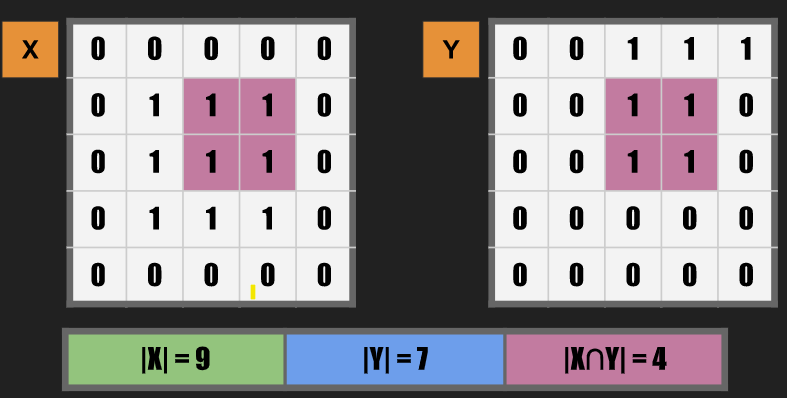
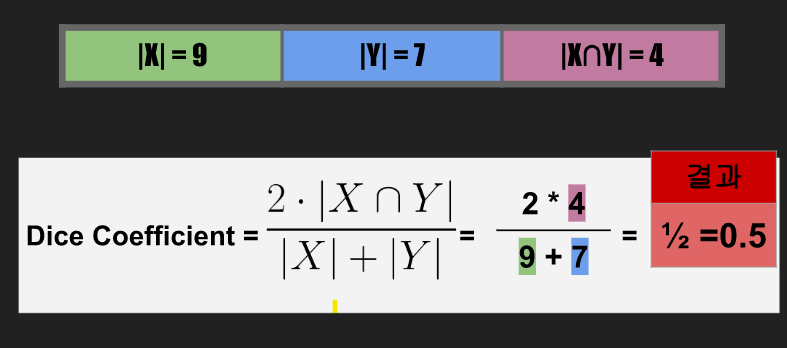

In [66]:
a=np.array([1, 2])
b=np.array([3, 4])
sum(a*b) # 3+8

11

In [12]:
from keras import backend as K
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    # (2. * K.sum(y_true_f * y_pred_f) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

simple_cnn.compile(optimizer = 'adam', 
                   loss = dice_coef_loss, 
                   metrics = [dice_coef, 'acc', 'mse'])

# Simple Training
여기에서 각 이미지가 자체 배치인 간단한 교육을 실행하지만(좋은 생각은 아님) 코드를 단순하게 유지합니다.


In [60]:
for _, c_row in train_img_df.iterrows():
    print(c_row)

Stage                                                  stage1
ImageId     00071198d059ba7f5914a526d124d28e6d010c92466da2...
masks       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
images      [[[0.0196078431372549, 0.0196078431372549, 0.0...
Red                                                  0.024087
Green                                                0.024087
Blue                                                 0.024087
Gray                                                 0.024087
Red-Blue                                                  0.0
Name: 0, dtype: object
Stage                                                  stage1
ImageId     003cee89357d9fe13516167fd67b609a164651b2193458...
masks       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
images      [[[0.0196078431372549, 0.0196078431372549, 0.0...
Red                                                  0.035367
Green                                                0.035367
Blue                                           

KeyboardInterrupt: 

In [13]:
def simple_gen():
    while True:
        for _, c_row in train_img_df.iterrows(): # _는 인덱스 자리, c_row는 df형태의 series
            yield np.expand_dims(c_row['images'],0), np.expand_dims(np.expand_dims(c_row['masks'],-1),0)
            # (1,n,m,3), (1,n,m,1)형태

simple_cnn.fit(simple_gen(), steps_per_epoch=train_img_df.shape[0], epochs = 3)

Epoch 1/3
670/670 [==============================] - 249s 370ms/step - loss: -0.6953 - dice_coef: 0.6953 - acc: 0.8423 - mse: 0.1486
Epoch 2/3
670/670 [==============================] - 252s 377ms/step - loss: -0.7922 - dice_coef: 0.7922 - acc: 0.8957 - mse: 0.0972
Epoch 3/3
670/670 [==============================] - 244s 364ms/step - loss: -0.8036 - dice_coef: 0.8036 - acc: 0.8911 - mse: 0.1043


In [57]:
for _, c_row in train_img_df.iterrows():
    print(np.expand_dims(c_row['images'],0)) 

[[[[0.01960784 0.01960784 0.01960784]
   [0.01960784 0.01960784 0.01960784]
   [0.01960784 0.01960784 0.01960784]
   ...
   [0.01568627 0.01568627 0.01568627]
   [0.01176471 0.01176471 0.01176471]
   [0.01176471 0.01176471 0.01176471]]

  [[0.02352941 0.02352941 0.02352941]
   [0.01960784 0.01960784 0.01960784]
   [0.01960784 0.01960784 0.01960784]
   ...
   [0.01568627 0.01568627 0.01568627]
   [0.01568627 0.01568627 0.01568627]
   [0.01176471 0.01176471 0.01176471]]

  [[0.02352941 0.02352941 0.02352941]
   [0.01960784 0.01960784 0.01960784]
   [0.01960784 0.01960784 0.01960784]
   ...
   [0.01960784 0.01960784 0.01960784]
   [0.01568627 0.01568627 0.01568627]
   [0.01176471 0.01176471 0.01176471]]

  ...

  [[0.01176471 0.01176471 0.01176471]
   [0.01176471 0.01176471 0.01176471]
   [0.01176471 0.01176471 0.01176471]
   ...
   [0.00784314 0.00784314 0.00784314]
   [0.00784314 0.00784314 0.00784314]
   [0.01176471 0.01176471 0.01176471]]

  [[0.01176471 0.01176471 0.01176471]
   [0.0

In [58]:
for _, c_row in train_img_df.iterrows():
    print(c_row['images']) 

[[[0.01960784 0.01960784 0.01960784]
  [0.01960784 0.01960784 0.01960784]
  [0.01960784 0.01960784 0.01960784]
  ...
  [0.01568627 0.01568627 0.01568627]
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]]

 [[0.02352941 0.02352941 0.02352941]
  [0.01960784 0.01960784 0.01960784]
  [0.01960784 0.01960784 0.01960784]
  ...
  [0.01568627 0.01568627 0.01568627]
  [0.01568627 0.01568627 0.01568627]
  [0.01176471 0.01176471 0.01176471]]

 [[0.02352941 0.02352941 0.02352941]
  [0.01960784 0.01960784 0.01960784]
  [0.01960784 0.01960784 0.01960784]
  ...
  [0.01960784 0.01960784 0.01960784]
  [0.01568627 0.01568627 0.01568627]
  [0.01176471 0.01176471 0.01176471]]

 ...

 [[0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  ...
  [0.00784314 0.00784314 0.00784314]
  [0.00784314 0.00784314 0.00784314]
  [0.01176471 0.01176471 0.01176471]]

 [[0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]


# Apply Model to Test
Here we apply the model to the test data

In [14]:
%%time
test_df = img_df.query('TrainingSplit=="test"')
test_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in test_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    test_rows += [c_row]
test_img_df = pd.DataFrame(test_rows)
test_img_df

Wall time: 524 ms


Stage                                            ImageId  \
0   stage1  0114f484a16c152baa2d82fdd43740880a762c93f436c8...   
1   stage1  0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...   
2   stage1  0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed3...   
3   stage1  0e132f71c8b4875c3c2dd7a22997468a3e842b46aa9bd4...   
4   stage1  0ed3555a4bd48046d3b63d8baf03a5aa97e523aa483aaa...   
..     ...                                                ...   
60  stage1  eea70a7948d25a9a791dbcb39228af4ea4049fe5ebdee9...   
61  stage1  f0d0ab13ff53adc3c4d57e95a5f83d80b06f2cbc0bf002...   
62  stage1  f5effed21f671bbf4551ecebb7fe95f3be1cf09c16a60a...   
63  stage1  fac507fa4d1649e8b24c195d990f1fc3ca3633d917839e...   
64  stage1  fe9adb627a6f45747c5a8223b671774791ededf9364f65...   

                                               images  
0   [.\input\stage1_test\0114f484a16c152baa2d82fdd...  
1   [.\input\stage1_test\0999dab07b11bc85fb8464fc3...  
2   [.\input\stage1_test\0a849e0eb15faa8a6d7329c3d...  
3   [.\input\stage1_test\0e132f71c8b4875c3c2dd7a22...  
4   [.\input\stage1_test\0ed3555a4bd48046d3b63d8ba...  
..                                                ...  
60  [.\input\stage1_test\eea70a7948d25a9a791dbcb39...  
61  [.\input\stage1_test\f0d0ab13ff53adc3c4d57e95a...  
62  [.\input\stage1_test\f5effed21f671bbf4551ecebb...  
63  [.\input\stage1_test\fac507fa4d1649e8b24c195d9...  
64  [.\input\stage1_test\fe9adb627a6f45747c5a8223b...  

[65 rows x 3 columns]

In [15]:
%%time
test_df = img_df.query('TrainingSplit=="test"')
test_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in test_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    test_rows += [c_row]
test_img_df = pd.DataFrame(test_rows)    

test_img_df['images'] = test_img_df['images'].map(read_and_stack).map(lambda x: x[:,:,:IMG_CHANNELS])
print(test_img_df.shape[0], 'images to process')
test_img_df.sample(1)

65 images to process
Wall time: 1.51 s


Stage                                            ImageId  \
21  stage1  43a71aeb641faa18742cb826772a8566c6c947d7050f9a...   

                                               images  
21  [[[0.08627450980392157, 0.08627450980392157, 0...

In [16]:
%%time
test_img_df['masks'] = test_img_df['images'].map(lambda x: simple_cnn.predict(np.expand_dims(x, 0))[0, :, :, 0])
test_img_df

Wall time: 11.8 s


Stage                                            ImageId  \
0   stage1  0114f484a16c152baa2d82fdd43740880a762c93f436c8...   
1   stage1  0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...   
2   stage1  0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed3...   
3   stage1  0e132f71c8b4875c3c2dd7a22997468a3e842b46aa9bd4...   
4   stage1  0ed3555a4bd48046d3b63d8baf03a5aa97e523aa483aaa...   
..     ...                                                ...   
60  stage1  eea70a7948d25a9a791dbcb39228af4ea4049fe5ebdee9...   
61  stage1  f0d0ab13ff53adc3c4d57e95a5f83d80b06f2cbc0bf002...   
62  stage1  f5effed21f671bbf4551ecebb7fe95f3be1cf09c16a60a...   
63  stage1  fac507fa4d1649e8b24c195d990f1fc3ca3633d917839e...   
64  stage1  fe9adb627a6f45747c5a8223b671774791ededf9364f65...   

                                               images  \
0   [[[0.011764705882352941, 0.011764705882352941,...   
1   [[[0.0784313725490196, 0.0784313725490196, 0.0...   
2   [[[0.07058823529411765, 0.07058823529411765, 0...   
3   [[[0.050980392156862744, 0.050980392156862744,...   
4   [[[0.054901960784313725, 0.054901960784313725,...   
..                                                ...   
60  [[[0.19215686274509805, 0.19215686274509805, 0...   
61  [[[0.050980392156862744, 0.050980392156862744,...   
62  [[[0.5529411764705883, 0.3686274509803922, 0.5...   
63  [[[0.06274509803921569, 0.06274509803921569, 0...   
64  [[[0.14901960784313725, 0.14901960784313725, 0...   

                                                masks  
0   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
1   [[8.784541e-36, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2   [[5.456675e-35, 0.0, 0.0, 0.0, 2.6974284e-36, ...  
3   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
4   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
..                                                ...  
60  [[8.1158435e-16, 6.0363834e-24, 6.901637e-38, ...  
61  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
62  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...  
63  [[3.937705e-37, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
64  [[1.3562726e-24, 5.365769e-35, 0.0, 0.0, 0.0, ...  

[65 rows x 4 columns]

## Show a few predictions

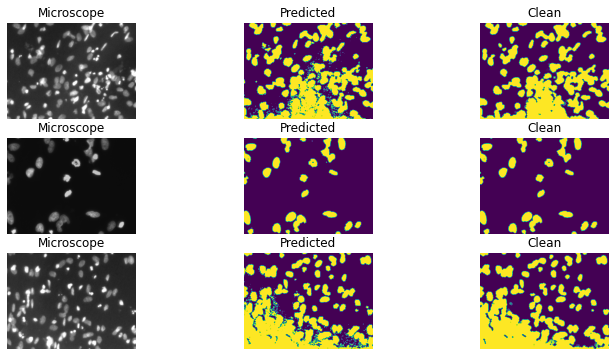

In [18]:
n_img = 3
from skimage.morphology import closing, opening, disk
def clean_img(x):
    return opening(closing(x, disk(1)), disk(3))
fig, m_axs = plt.subplots(3, n_img, figsize = (12, 6))
for (_, d_row), (c_im, c_lab, c_clean) in zip(test_img_df.sample(n_img).iterrows(), 
                                     m_axs):
    c_im.imshow(d_row['images'])
    c_im.axis('off')
    c_im.set_title('Microscope')
    
    c_lab.imshow(d_row['masks'])
    c_lab.axis('off')
    c_lab.set_title('Predicted')
    
    c_clean.imshow(clean_img(d_row['masks']))
    c_clean.axis('off')
    c_clean.set_title('Clean')

# Check RLE
Check that our approach for RLE encoding (stolen from [here](https://www.kaggle.com/rakhlin/fast-run-length-encoding-python)) works

In [19]:
from skimage.morphology import label # label regions
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): 
            run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cut_off = 0.5):
    lab_img = label(x>cut_off)
    if lab_img.max()<1:
        lab_img[0,0] = 1 # ensure at least one prediction per image
    for i in range(1, lab_img.max()+1):
        yield rle_encoding(lab_img==i)

## Calculate the RLEs for a Train Image

In [49]:
lab_img = label(train_rle_row['masks']>0.5)
lab_img.max()

13

In [52]:
lab_img==1

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [54]:
(lab_img==1).T.flatten()

array([False, False, False, ..., False, False, False])

In [56]:
dots = np.where((lab_img==1).T.flatten()==1)[0]
dots

array([25124, 25125, 25126, 25127, 25128, 25129, 25130, 25131, 25132,
       25133, 25379, 25380, 25381, 25382, 25383, 25384, 25385, 25386,
       25387, 25388, 25389, 25390, 25634, 25635, 25636, 25637, 25638,
       25639, 25640, 25641, 25642, 25643, 25644, 25645, 25646, 25890,
       25891, 25892, 25893, 25894, 25895, 25896, 25897, 25898, 25899,
       25900, 25901, 25902, 25903, 26146, 26147, 26148, 26149, 26150,
       26151, 26152, 26153, 26154, 26155, 26156, 26157, 26158, 26159,
       26402, 26403, 26404, 26405, 26406, 26407, 26408, 26409, 26410,
       26411, 26412, 26413, 26414, 26415, 26658, 26659, 26660, 26661,
       26662, 26663, 26664, 26665, 26666, 26667, 26668, 26669, 26670,
       26671, 26672, 26914, 26915, 26916, 26917, 26918, 26919, 26920,
       26921, 26922, 26923, 26924, 26925, 26926, 26927, 27171, 27172,
       27173, 27174, 27175, 27176, 27177, 27178, 27179, 27180, 27181,
       27182, 27427, 27428, 27429, 27430, 27431, 27432, 27433, 27434,
       27435, 27436,

In [20]:
_, train_rle_row = next(train_img_df.tail(5).iterrows()) 
train_row_rles = list(prob_to_rles(train_rle_row['masks']))
train_row_rles

[[25125,
  10,
  25380,
  12,
  25635,
  13,
  25891,
  14,
  26147,
  14,
  26403,
  14,
  26659,
  15,
  26915,
  14,
  27172,
  12,
  27428,
  11,
  27684,
  10,
  27941,
  8,
  28198,
  6,
  28455,
  2],
 [11561,
  4,
  11815,
  9,
  12070,
  12,
  12326,
  14,
  12582,
  14,
  12838,
  14,
  13095,
  13,
  13351,
  14,
  13607,
  14,
  13863,
  14,
  14120,
  13,
  14376,
  12,
  14632,
  12,
  14888,
  11,
  15144,
  11,
  15401,
  9,
  15657,
  8,
  15914,
  6,
  16171,
  3],
 [15691,
  1,
  15945,
  4,
  16201,
  7,
  16456,
  8,
  16711,
  10,
  16967,
  10,
  17223,
  10,
  17478,
  11,
  17734,
  11,
  17990,
  11,
  18245,
  12,
  18500,
  13,
  18756,
  13,
  19012,
  13,
  19269,
  12,
  19525,
  12,
  19782,
  11,
  20039,
  9],
 [11879,
  4,
  12133,
  9,
  12388,
  11,
  12643,
  12,
  12898,
  13,
  13153,
  15,
  13409,
  14,
  13665,
  14,
  13921,
  13,
  14178,
  11,
  14435,
  9,
  14693,
  5],
 [870, 7, 1124, 9, 1380, 10, 1635, 11, 1891, 11, 2147, 11, 2404, 8, 2

In [40]:
train_rle_row

Stage                                                  stage1
ImageId     fec226e45f49ab81ab71e0eaa1248ba09b56a328338dce...
masks       [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
images      [[[0.043137254901960784, 0.043137254901960784,...
Red                                                  0.062943
Green                                                0.062943
Blue                                                 0.062943
Gray                                                 0.062943
Red-Blue                                                  0.0
Name: 665, dtype: object

## Take the RLEs from the CSV

In [51]:
tl_rles = train_labels.query('ImageId=="{ImageId}"'.format(**train_rle_row))
tl_rles

ImageId  \
29354  fec226e45f49ab81ab71e0eaa1248ba09b56a328338dce...   
29355  fec226e45f49ab81ab71e0eaa1248ba09b56a328338dce...   
29356  fec226e45f49ab81ab71e0eaa1248ba09b56a328338dce...   
29357  fec226e45f49ab81ab71e0eaa1248ba09b56a328338dce...   
29358  fec226e45f49ab81ab71e0eaa1248ba09b56a328338dce...   
29359  fec226e45f49ab81ab71e0eaa1248ba09b56a328338dce...   
29360  fec226e45f49ab81ab71e0eaa1248ba09b56a328338dce...   
29361  fec226e45f49ab81ab71e0eaa1248ba09b56a328338dce...   
29362  fec226e45f49ab81ab71e0eaa1248ba09b56a328338dce...   
29363  fec226e45f49ab81ab71e0eaa1248ba09b56a328338dce...   
29364  fec226e45f49ab81ab71e0eaa1248ba09b56a328338dce...   
29365  fec226e45f49ab81ab71e0eaa1248ba09b56a328338dce...   
29366  fec226e45f49ab81ab71e0eaa1248ba09b56a328338dce...   

                                           EncodedPixels  
29354  [7853, 6, 8108, 8, 8364, 9, 8620, 9, 8876, 9, ...  
29355  [38270, 2, 38525, 4, 38779, 8, 39034, 14, 3929...  
29356  [9632, 4, 9887, 7, 10142, 8, 10398, 9, 10653, ...  
29357  [32190, 3, 32445, 6, 32700, 10, 32956, 12, 332...  
29358  [11879, 4, 12133, 9, 12388, 11, 12643, 12, 128...  
29359  [12027, 3, 12282, 5, 12538, 5, 12793, 6, 13049...  
29360  [15691, 1, 15945, 4, 16201, 7, 16456, 8, 16711...  
29361  [25125, 10, 25380, 12, 25635, 13, 25891, 14, 2...  
29362  [32998, 5, 33252, 8, 33507, 10, 33763, 10, 340...  
29363  [22462, 2, 22717, 5, 22972, 7, 23227, 9, 23483...  
29364  [11561, 4, 11815, 9, 12070, 12, 12326, 14, 125...  
29365  [870, 7, 1124, 9, 1380, 10, 1635, 11, 1891, 11...  
29366  [44773, 2, 45026, 8, 45280, 11, 45534, 13, 457...

In [21]:
tl_rles = train_labels.query('ImageId=="{ImageId}"'.format(**train_rle_row))['EncodedPixels']
tl_rles

29354    [7853, 6, 8108, 8, 8364, 9, 8620, 9, 8876, 9, ...
29355    [38270, 2, 38525, 4, 38779, 8, 39034, 14, 3929...
29356    [9632, 4, 9887, 7, 10142, 8, 10398, 9, 10653, ...
29357    [32190, 3, 32445, 6, 32700, 10, 32956, 12, 332...
29358    [11879, 4, 12133, 9, 12388, 11, 12643, 12, 128...
29359    [12027, 3, 12282, 5, 12538, 5, 12793, 6, 13049...
29360    [15691, 1, 15945, 4, 16201, 7, 16456, 8, 16711...
29361    [25125, 10, 25380, 12, 25635, 13, 25891, 14, 2...
29362    [32998, 5, 33252, 8, 33507, 10, 33763, 10, 340...
29363    [22462, 2, 22717, 5, 22972, 7, 23227, 9, 23483...
29364    [11561, 4, 11815, 9, 12070, 12, 12326, 14, 125...
29365    [870, 7, 1124, 9, 1380, 10, 1635, 11, 1891, 11...
29366    [44773, 2, 45026, 8, 45280, 11, 45534, 13, 457...
Name: EncodedPixels, dtype: object

## Check
몇 가지 단순화를 했기 때문에 모든 것이 완벽하지는 않지만 거의 비슷할 것으로 예상됩니다.


In [22]:
match, mismatch = 0, 0
for img_rle, train_rle in zip(sorted(train_row_rles, key = lambda x: x[0]), 
                             sorted(tl_rles, key = lambda x: x[0])):
    for i_x, i_y in zip(img_rle, train_rle):
        if i_x == i_y:
            match += 1
        else:
            mismatch += 1
print('Matches: %d, Mismatches: %d, Accuracy: %2.1f%%' % (match, mismatch, 100.0*match/(match+mismatch)))

Matches: 360, Mismatches: 0, Accuracy: 100.0%


# Calculate RLE for all the masks
여기서는 모든 마스크에 대한 RLE를 생성하고 결과를 테이블로 출력합니다. 이미지가 매우 지저분할 수 있으므로 제출 전에 몇 가지 형태학적 작업을 사용하여 이미지를 정리합니다(단일 픽셀 제거, 인근 지역 연결 등).

In [23]:
test_img_df['rles'] = test_img_df['masks'].map(clean_img).map(lambda x: list(prob_to_rles(x)))
test_img_df

Stage                                            ImageId  \
0   stage1  0114f484a16c152baa2d82fdd43740880a762c93f436c8...   
1   stage1  0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...   
2   stage1  0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed3...   
3   stage1  0e132f71c8b4875c3c2dd7a22997468a3e842b46aa9bd4...   
4   stage1  0ed3555a4bd48046d3b63d8baf03a5aa97e523aa483aaa...   
..     ...                                                ...   
60  stage1  eea70a7948d25a9a791dbcb39228af4ea4049fe5ebdee9...   
61  stage1  f0d0ab13ff53adc3c4d57e95a5f83d80b06f2cbc0bf002...   
62  stage1  f5effed21f671bbf4551ecebb7fe95f3be1cf09c16a60a...   
63  stage1  fac507fa4d1649e8b24c195d990f1fc3ca3633d917839e...   
64  stage1  fe9adb627a6f45747c5a8223b671774791ededf9364f65...   

                                               images  \
0   [[[0.011764705882352941, 0.011764705882352941,...   
1   [[[0.0784313725490196, 0.0784313725490196, 0.0...   
2   [[[0.07058823529411765, 0.07058823529411765, 0...   
3   [[[0.050980392156862744, 0.050980392156862744,...   
4   [[[0.054901960784313725, 0.054901960784313725,...   
..                                                ...   
60  [[[0.19215686274509805, 0.19215686274509805, 0...   
61  [[[0.050980392156862744, 0.050980392156862744,...   
62  [[[0.5529411764705883, 0.3686274509803922, 0.5...   
63  [[[0.06274509803921569, 0.06274509803921569, 0...   
64  [[[0.14901960784313725, 0.14901960784313725, 0...   

                                                masks  \
0   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1   [[8.784541e-36, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2   [[5.456675e-35, 0.0, 0.0, 0.0, 2.6974284e-36, ...   
3   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
4   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
..                                                ...   
60  [[8.1158435e-16, 6.0363834e-24, 6.901637e-38, ...   
61  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
62  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...   
63  [[3.937705e-37, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
64  [[1.3562726e-24, 5.365769e-35, 0.0, 0.0, 0.0, ...   

                                                 rles  
0   [[45106, 5, 45360, 9, 45615, 10, 45871, 11, 46...  
1   [[47230, 1, 47749, 3, 48268, 4, 48787, 4, 4930...  
2   [[1793, 1, 2049, 3, 2087, 3, 2305, 4, 2339, 9,...  
3   [[47626, 4, 47880, 8, 48136, 9, 48391, 10, 486...  
4   [[34049, 6, 34305, 8, 34561, 9, 34817, 9, 3507...  
..                                                ...  
60  [[11424, 8, 11941, 13, 12458, 17, 12976, 20, 1...  
61  [[317747, 4, 318265, 9, 318783, 13, 319302, 16...  
62  [[1, 1584, 1587, 509, 2100, 508, 2613, 505, 31...  
63  [[14852, 1, 15106, 5, 15361, 7, 15617, 7, 1587...  
64  [[9217, 1, 9473, 3, 9729, 3, 9985, 4, 10241, 4...  

[65 rows x 5 columns]

In [38]:
out_pred_list = []
for _, c_row in test_img_df.iterrows():
    for c_rle in c_row['rles']:
        out_pred_list+=[dict(ImageId=c_row['ImageId'], 
                             EncodedPixels = ' '.join(np.array(c_rle).astype(str)))]

out_pred_df = pd.DataFrame(out_pred_list)
print(out_pred_df.shape[0], 'regions found for', test_img_df.shape[0], 'images')
out_pred_df.sample(3)

1566 regions found for 65 images


ImageId  \
1265  d6eb7ce7723e2f6dc13b90b41a29ded27dbd815bad633f...   
560   53df5150ee56253fe5bc91a9230d377bb21f1300f443ba...   
35    0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...   

                                          EncodedPixels  
1265  110937 4 111455 8 111975 10 112494 11 113015 1...  
560   21606 1 21860 5 22115 8 22371 8 22626 10 22883...  
35    92782 3 93299 7 93817 8 94336 9 94854 10 95373...

In [39]:
out_pred_df[['ImageId', 'EncodedPixels']].to_csv('predictions.csv', index = False)